In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline



### Loading data from CSV file
    - We look into the details about the dataset:
        - 1754884 rows 
        - 7 columns: User_id, Merchant_id, Coupon_id,Discount_rate, Distance, Date_received, Date 
        - Changed to datetime by using parse_dates pandas function when we load the data

In [3]:
offline = pd.read_csv('ccf_offline_stage1_train.csv', parse_dates=['Date_received','Date'])
offline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   User_id        int64         
 1   Merchant_id    int64         
 2   Coupon_id      float64       
 3   Discount_rate  object        
 4   Distance       float64       
 5   Date_received  datetime64[ns]
 6   Date           datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 93.7+ MB


In [4]:
offline.head(10)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,150:20,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,20:1,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,20:1,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,20:1,0.0,2016-06-13,NaT
5,1439408,2632,NaN,NaN,0.0,NaT,2016-05-16
6,1439408,2632,8591.0,20:1,0.0,2016-05-16,2016-06-13
7,1832624,3381,7610.0,200:20,0.0,2016-04-29,NaT
8,2029232,3381,11951.0,200:20,1.0,2016-01-29,NaT
9,2029232,450,1532.0,30:5,0.0,2016-05-30,NaT


### 2. Cleaning data
    - Handling null values: Coupon_id, Discount_rate, and Date_received have the same number of null values. This is because if there is no coupon issued, it implies that the context doesn't involve customers receiving and using a coupon.
    
    

In [5]:
offline.isnull().sum()

User_id               0
Merchant_id           0
Coupon_id        701602
Discount_rate    701602
Distance         106003
Date_received    701602
Date             977900
dtype: int64

### 2.1 Convert the 'Discount_rate' column's data to float.

In [6]:
offline['Discount_rate'] = offline['Discount_rate'].fillna('null')
offline.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,null,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,150:20,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,20:1,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,20:1,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,20:1,0.0,2016-06-13,NaT


In [7]:
# for example 150:20 the discount rate like (150-20)/150 = 0.87 
def discount_rate_opt(s):
    if ':' in s:
        split = s.split(':')
        discount_rate = (int(split[0]) - int(split[1]))/int(split[0]) 
        return round(discount_rate,2)
    elif s == 'null':
        return np.NAN
    else:
        return float(s) 
offline['Discount_rate']  = offline['Discount_rate'].map(discount_rate_opt)
offline.head()


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,0.87,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,0.95,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,0.95,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,0.95,0.0,2016-06-13,NaT


### 2.2 Categorization of Transactions based on Date and Coupon Status
    - If Date is null and Coupon_id is not null, it indicates a coupon not consumed (cpon_no_consume).
    - If Date is null and Coupon_id is null, it indicates no coupon and no consumption (no_cpon_no_consume).
    - If Date is not null and Coupon_id is null, it indicates Consumed without coupon (no_cpon_consume).
    - If Date is not null and Coupon_id is not null, it indicates Consumed with coupon (cpon_consume)

In [8]:
nan1 = offline['Coupon_id'].isnull()  
nan2 = offline['Date_received'].isnull()
np.all(nan1 == nan2)

True

In [9]:
nan3 = offline['Discount_rate'].isnull()
np.all(nan1 == nan3)

True

In [10]:
cpon_no_consume = offline[(offline['Date'].isnull() & offline['Coupon_id'].notnull())]
no_cpon_no_consume = offline[(offline['Date'].isnull() & offline['Coupon_id'].isnull())]
no_cpon_consume = offline[(offline['Date'].notnull() & offline['Coupon_id'].isnull())]
cpon_consume  = offline[(offline['Date'].notnull() & offline['Coupon_id'].notnull())]

In [11]:
print('A coupon never consumed:{}'.format(len(cpon_no_consume)))
print('No coupon and no consumption:{}'.format(len(no_cpon_no_consume))) # no need to consider
print('Consumed without coupon:{}'.format(len(no_cpon_consume)))
print('Consumed with coupon:{}'.format(len(cpon_consume)))

A coupon never consumed:977900
No coupon and no consumption:0
Consumed without coupon:701602
Consumed with coupon:75382


### The number of users who utilized coupons for consumption is 70k, which is relatively small portion compared to other users

## 3.EDA


#### 3.1 using pie chart to illustrate the porportion of each coupon status

In [12]:
consume_status_dict = {'cpon_no_consume':len(cpon_no_consume),'no_cpon_consume':len(no_cpon_consume),'cpon_consume':len(cpon_consume)}
consume_status = pd.Series(consume_status_dict)
consume_status

cpon_no_consume    977900
no_cpon_consume    701602
cpon_consume        75382
dtype: int64

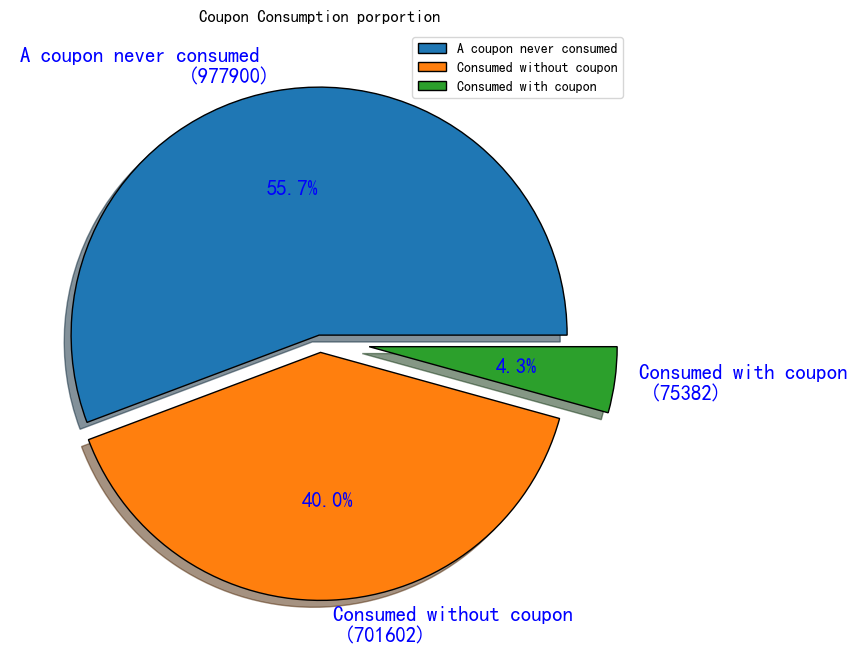

In [13]:
fig,ax=plt.subplots(1,1,figsize=(8,10))
consume_status.plot.pie(ax = ax,
                       autopct='%1.1f%%',
                       shadow=True,
                        explode=[0.02,0.05,0.2],
                        textprops={'fontsize':15,'color':'blue'},
                        wedgeprops={'linewidth':1,'edgecolor':'black'},
                        labels=['A coupon never consumed \n ({})'.format(len(cpon_no_consume)),
                                'Consumed without coupon \n ({})'.format(len(no_cpon_consume)),
                               'Consumed with coupon \n ({})'.format(len(cpon_consume))
                               ]
                       )
ax.set_ylabel('')  #去除ylable
ax.set_title('Coupon Consumption porportion')
plt.legend(labels=['A coupon never consumed','Consumed without coupon','Consumed with coupon'])

#### 3.2Analyze the distance and discount rates among the group of users who have consumed coupons

In [14]:
Merchant_distance = cpon_consume.groupby('Merchant_id')['Distance'].mean()
Merchant_distance[Merchant_distance==0]
#There are 4,076 merchants, and among them, 1,431 merchants have coupon-consumed users with an average range within 500 meters.

Merchant_id
3       0.0
4       0.0
13      0.0
14      0.0
18      0.0
       ... 
8806    0.0
8824    0.0
8828    0.0
8849    0.0
8856    0.0
Name: Distance, Length: 1431, dtype: float64

<Axes: >

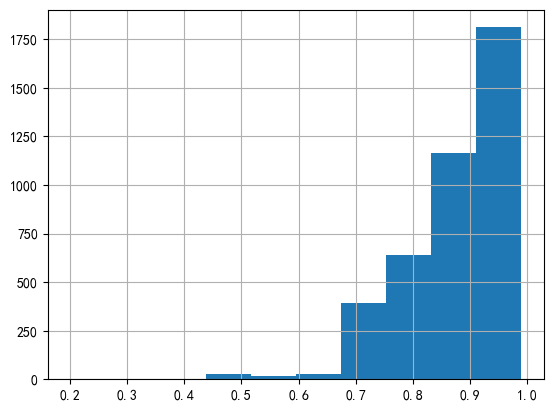

In [15]:
#The average discount intensity of customers visiting each merchant for in-store consumption.
Merchant_discount_rate = cpon_consume.groupby('Merchant_id')['Discount_rate'].mean()
Merchant_discount_rate.sort_values()
Merchant_discount_rate.hist()


In [16]:
Merchant_discount_rate.mean() 


0.8847410562670716

#### 3.3 Top merchant with the highest number of coupon consumers.

In [17]:
#count number of distinct consumer by each merchant store 
popular_merchant = cpon_consume.groupby('Merchant_id')['User_id'].apply(lambda x:len(x.unique())).sort_values(ascending=False)
#extract merchant who has more than 500 consumers
popular_merchant500 = popular_merchant[popular_merchant>500]
popular_merchant500.name = 'customer_count' #rename
print(len(popular_merchant500))
print(popular_merchant500)


16
Merchant_id
5341    2800
760     2627
3381    2248
6485    2029
2099    1401
2934    1310
450     1094
3532     968
7555     925
1520     870
6901     855
3621     851
4142     832
1379     587
1469     584
1433     559
Name: customer_count, dtype: int64


- There are a total of 16 stores with coupon-consumed customers exceeding 500.
- The store with the highest number of customers using coupons for consumption is 5,341, and the lowest number among them is 2,800.
- The last-ranked store has 559 customers using coupons for consumption.
- These businesses exhibit effective coupon utilization, demonstrating consumer preference for coupon-based transactions. There is potential for learning from their promotional strategies.

#### 3.4 For merchants with coupon-consumed customer counts exceeding 500,analyze the correlation between average customer distance to the store and average discount intensity.

In [18]:
#join table popular_merchant500 with Merchant_distance togetger
merchant_pop_dis = pd.merge(left=popular_merchant500,right=Merchant_distance,on='Merchant_id',how='inner')
merchant_pop_dis_rate = pd.merge(left=merchant_pop_dis,right=Merchant_discount_rate,on='Merchant_id',how='inner')
merchant_pop_dis_rate

,customer_count,Distance,Discount_rate
Merchant_id,,,
5341,2800,0.168598,0.826036
760,2627,0.349866,0.799873
3381,2248,1.652429,0.744150
6485,2029,0.368567,0.770439
2099,1401,0.968072,0.900000
2934,1310,1.114833,0.830000
450,1094,0.892164,0.819274
3532,968,0.272498,0.852289
7555,925,1.329977,0.828381


In [19]:
merchant_pop_dis_rate.corr()


,customer_count,Distance,Discount_rate
customer_count,1.000000,-0.306180,-0.204102
Distance,-0.306180,1.000000,-0.397376
Discount_rate,-0.204102,-0.397376,1.000000


<Axes: >

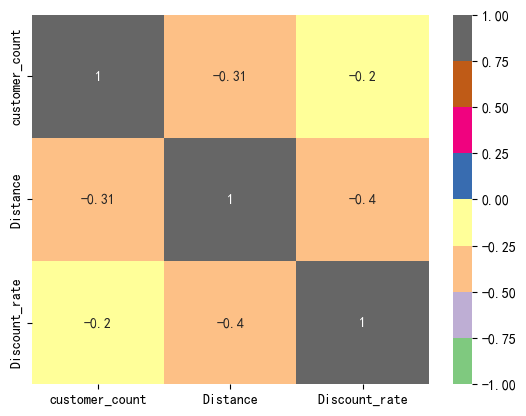

In [20]:
sns.heatmap(data=merchant_pop_dis_rate.corr(),annot=True,cmap='Accent',vmax=1,vmin=-1)


- The number of in-store customers shows a negative correlation with the distance customers travel to the store, with a correlation coefficient of 0.31, falling between 0.3 and 0.5, indicating a low correlation.

- The number of in-store customers exhibits a negative correlation with the discount intensity, with a correlation coefficient of 0.2, falling between 0 and 0.3, indicating an extremely weak correlation.
- In conclusion, the popularity of these stores is likely driven by the attractiveness of their products at reasonable prices. The correlation with distance and discount intensity is not significant.

### 4. Analyze the overall issuing and usage of coupons on a daily basis.
    - Business Analysis: Dates (Date_received for coupon issuance and date for coupon usage) serve as the x-axis for charts.
    - The goal is to calculate the daily count of coupon issuances and redemptions.

In [21]:
#total number of coupon consuming
offline['Date'].notnull().sum() 


776984

In [22]:
#total number of coupon issuing
offline['Date_received'].notnull().sum()  



1053282

In [24]:
#extract distinct coupon consumed records 
date_sort = offline[offline['Date'].notnull()]['Date'].sort_values().unique()
date_sort[:5]

array(['2016-01-01T00:00:00.000000000', '2016-01-02T00:00:00.000000000',
       '2016-01-03T00:00:00.000000000', '2016-01-04T00:00:00.000000000',
       '2016-01-05T00:00:00.000000000'], dtype='datetime64[ns]')

In [26]:
#extract distinct coupon received records 
date_received_sort = offline[offline['Date_received'].notnull()]['Date_received'].sort_values().unique()
date_received_sort[:5]


array(['2016-01-01T00:00:00.000000000', '2016-01-02T00:00:00.000000000',
       '2016-01-03T00:00:00.000000000', '2016-01-04T00:00:00.000000000',
       '2016-01-05T00:00:00.000000000'], dtype='datetime64[ns]')

In [58]:
#the number of coupon consumed by customers per day
consume_num_everyday =  cpon_consume[['User_id','Date_received']]
consume_num_everyday = consume_num_everyday.groupby('Date_received').count()
consume_num_everyday = consume_num_everyday.rename(columns={'User_id':'count'})
consume_num_everyday


,count
Date_received,
2016-01-01,74
2016-01-02,67
2016-01-03,74
2016-01-04,98
2016-01-05,107
...,...
2016-06-11,351
2016-06-12,330
2016-06-13,439


In [61]:
#the number of coupon issued per day(extract Date_received ！=null，count by per day)
coupon_issued_everyday = offline[offline['Date_received'].notnull()][['Date_received','User_id']]
coupon_issued_everyday = coupon_issued_everyday.groupby('Date_received').count()
coupon_issued_everyday = coupon_issued_everyday.rename(columns={'User_id':'count'})
coupon_issued_everyday

,count
Date_received,
2016-01-01,554
2016-01-02,542
2016-01-03,536
2016-01-04,577
2016-01-05,691
...,...
2016-06-11,5211
2016-06-12,4005
2016-06-13,7861


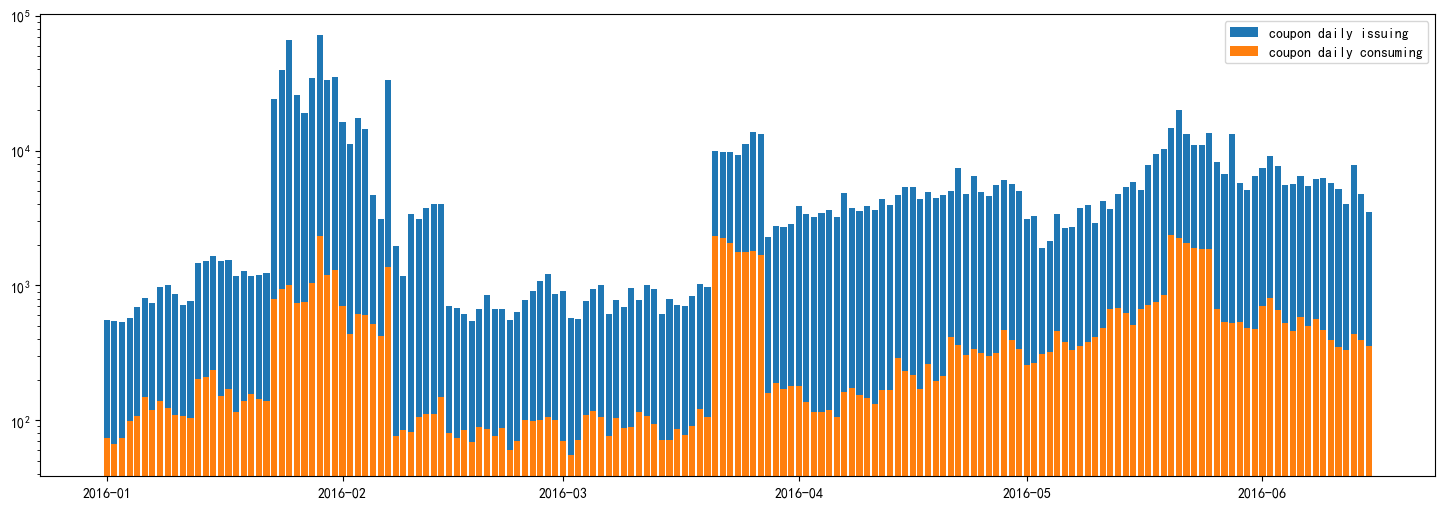

In [63]:

plt.figure(figsize=(18,6))

#plot coupon daily issuing 
plt.bar(x=date_received_sort,height=coupon_issued_everyday['count'],label='coupon daily issuing')
#plot coupon daily consuming
plt.bar(x=date_received_sort,height=consume_num_everyday['count'],label='coupon daily consuming')

plt.yscale('log')
plt.legend()


- For example, in February 2016, with a coupon issuance level around 1,000 and a distribution volume of around 100,000, the gap is approximately 100-fold, indicating very low utilization.

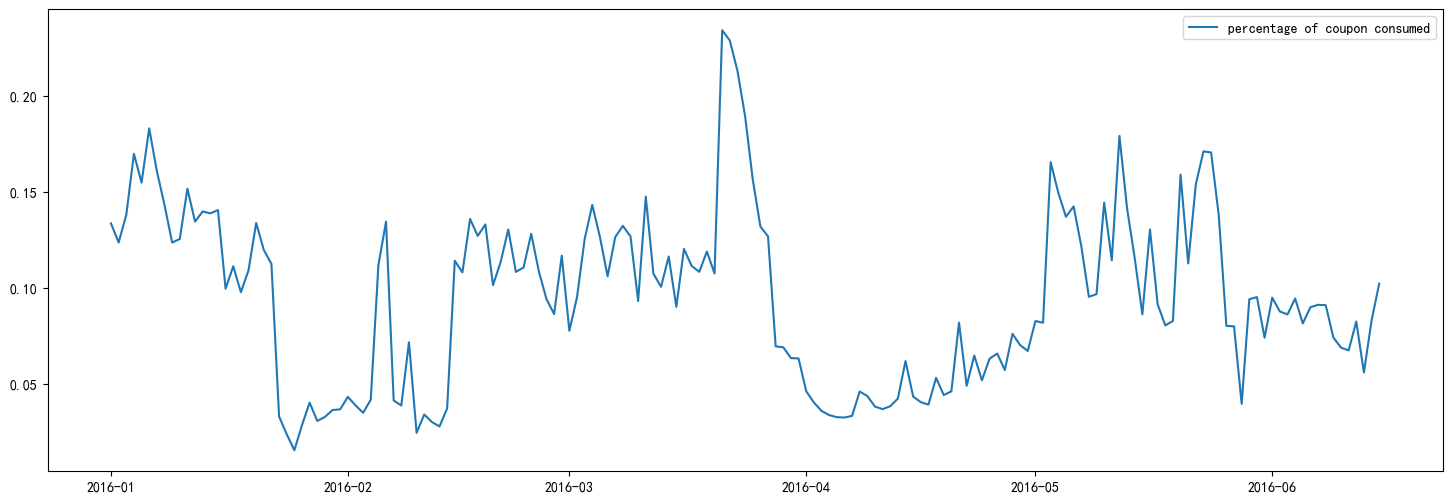

In [67]:
#Calculate the daily percentage of coupon consumed relative to the issuance volume.
plt.figure(figsize=(18,6))
plt.plot(date_received_sort,consume_num_everday['count']/coupon_sendout_everyday['count'],
       label='percentage of coupon consumed')
plt.legend()


- From the chart, it is evident that the highest coupon utilization rate occurred at the end of March 2016, reaching 30%.
- The lowest utilization rate was around 3% at the end of January 2016.
- Overall, there is significant fluctuation in coupon utilization rates.